<a href="https://colab.research.google.com/github/Booss3my/Ganimons/blob/main/Ganimons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
from google.colab import files
from google.colab import drive
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torch.autograd import Variable
from torchsummary import summary

**Dataset upload (Pokemeon Black and White game sprites ~<1000 images ) + extraction**


The images contain different Pokemons on a blank background (RGB+apha channels) with different aspect Ratios.

**Autoencoding:**
Autoencoding is a generalization to the Principle Component Analysis (PCA) algorithm (to non-linear manifolds with help of non-linear activation functions). 

**Small recap on dimentionality reduction:** We project our data to a lower dimension subsbace while trying to keep most the information, in PCA we make basis out of the k eigenvectors corresponding the k greatest eigenvalues of the covariance matrix of the data.
(***Fast demo:*** The quantity of information contained in the data is measured by entropy, and the differential entropy of the data distribution (modeled as a Gaussian distribution) is proportional to the log determinant of the covariance matrix ($Σ=\mathbb{E}[(X-\mathbb{E}(X))(X-\mathbb{E}(X))^T])$ ) with an additive constant depending on the number of samples ($H(\Sigma)=\frac{N}{2}+\frac{N log(2\pi)}{2}+ \frac{log(det(Σ))}{2}$ with $N$ the number of samples) . Thus, the quantity of information is related to the sum of the log of the eigenvalues of the data convolution matrix ($det(\Sigma)=\prod_{\lambda \in A} \lambda$ with $A$ the set of eigenvalues of $\Sigma$).
Thus, the subspace of dimension k that maximises entropy is constructed by taking the k eigenvectors corresponding the k greatest eigenvalues of $Σ$).


**(To do)** 
**Different aspect ratios problem** ( smaller pokemons are more difficult to compress, less information in the image -> ) 

In [3]:
# 2 Mo dataset :)
uploaded = files.upload()

Saving black-white.zip to black-white.zip


In [4]:
%mkdir data
%mkdir data/extracted
dir="data/black-white" #preprocessed images
save_dir="data/extracted" #processed images 
with zipfile.ZipFile('black-white.zip', 'r') as zip_ref:
    zip_ref.extractall("data")

%rm black-white.zip


mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/extracted’: File exists


**Preprocessing functions**

In [5]:
def to_gray(img): #ccomvert to grayscale
  image=transforms.transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.ToTensor()])(img)
  return(image)


def bbox_find(img):  #finds a bounding box (using the alpha channel but can be done by hand since the dataset is very small )
  img=transforms.ToTensor()(img)  #2d input(alpha channel)
  line=torch.zeros(img.shape[1])
  col=torch.zeros(img.shape[2])

  i,a,x,y,w,h=0,0,0,0,0,0

  while i<img.shape[1] and a==0:
    a=1
    if torch.equal(img[0,i,:],line):
      y=i
      a=0
    i=i+1 
    if torch.equal(img[0,-i-1,:],line):
      a=0
      h=img.shape[1]-2*i 
    i=i+1 

  a,i=0,0
  while i<img.shape[2] and a==0:
    a=1
    if torch.equal(img[0,:,i],col):
      x=i
      a=0
    if torch.equal(img[0,:,-i-1],col):
      a=0
      w=img.shape[2]-2*i
    i=i+1 

  return(x,y,w+min(img.shape[2]-(y+h),6),h+min(img.shape[1]-(x+w),6))


def crop(image): #crops image to bbox
  [x,y,w,h]=bbox_find(image[:,:,3])
  #print("old bbox", y,y+h,x,x+w)
  tmp=max(w,h)
  #print("new bbox", y-(tmp-h)//2,y+(tmp+h)//2,x-(tmp-w)//2,x+(tmp+w)//2)
  img=image[max(y-(tmp-h)//2,0):min(y+(tmp+h)//2,image.shape[1]),max(x-(tmp-w)//2,0):min(x+(tmp+w)//2,image.shape[0]),:]

  return(img)

def upsamp(img,size):
  #np array input of h,w,c=4
  #finds bounding box then upsample the image to a size
  img=crop(img)
  img=transforms.ToTensor()(img)
  ups=nn.Upsample(size=(size, size), mode='bilinear')
  tmp=ups(img.view(1,4,img.shape[1],img.shape[2]))
  img = tmp.reshape(4,size,size)
  img = img.permute(1, 2, 0)
  img = img.detach().numpy()
  return img

**Apply preprocessing to all images then save them in a new folder**

In [6]:
files_=os.listdir(dir)
size=96 #size


for path in files_:
  if os.path.isfile(dir+"/"+path):
    im=upsamp(plt.imread(dir+"/"+path),size)
    plt.imsave(save_dir+"/"+path,im)

shutil.rmtree(dir)
dir=save_dir 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


145
48
668
590


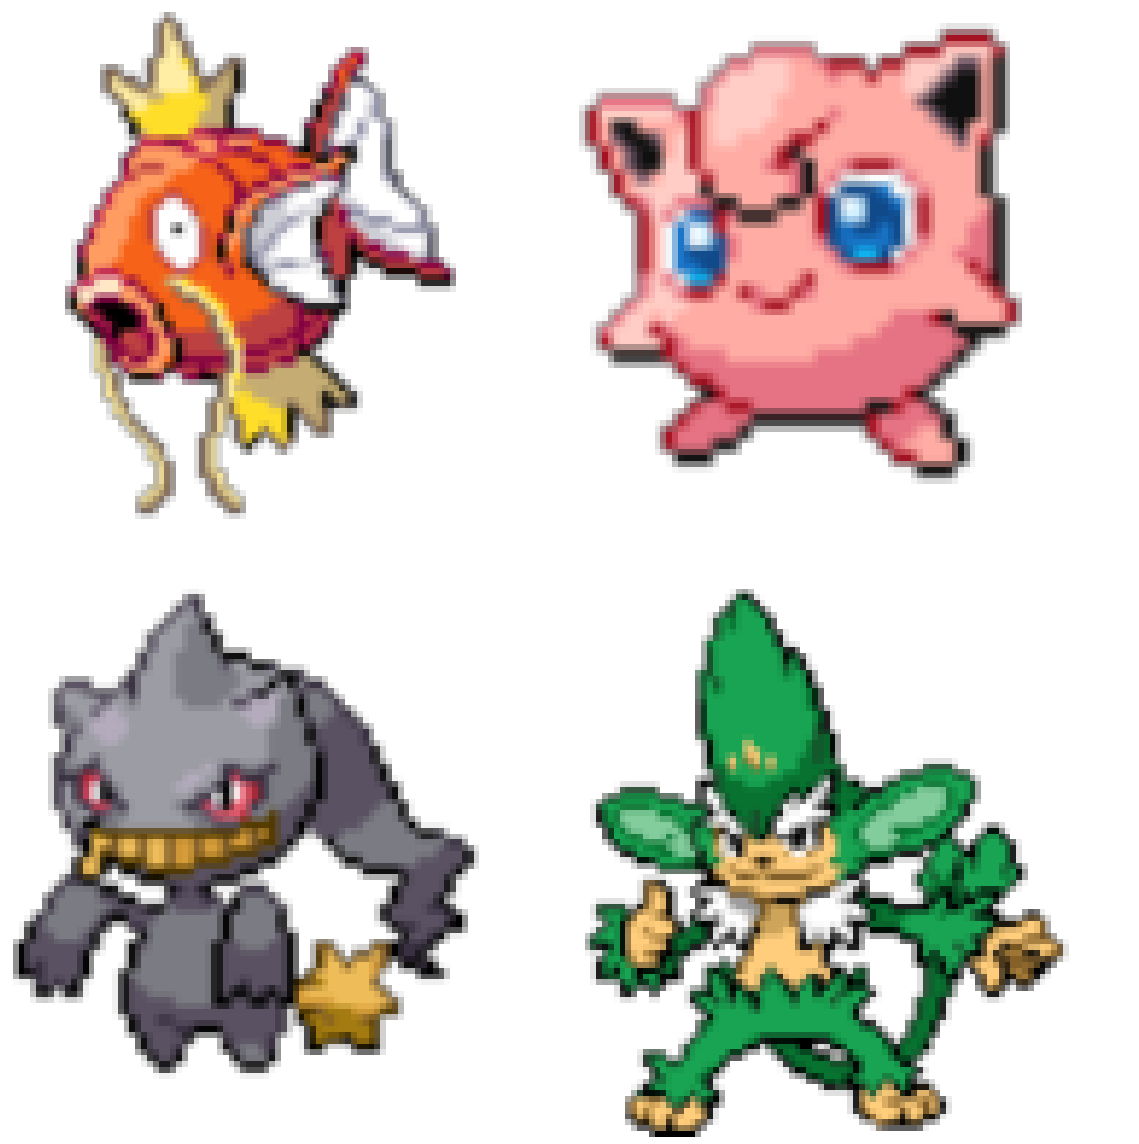

In [7]:
#test
files_=os.listdir(dir)
size=96
n = 2
rows=2
n_samples=n*rows
size=96
f, axs = plt.subplots(rows, n, figsize=(16, 16))

for j in range(n):
  for i in range(rows):
    idx=random.randint(0,len(files_))
    print(idx)
    image_path=os.path.join(dir,files_[idx])
    im=io.imread(image_path)
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
    
plt.tight_layout();


In [8]:
from numpy.core.numeric import False_
import gdown
#Autoencoder Hyperparameters

batch_size= 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate=0.00002
num_epochs=300
#theta = 0 #control the importance of the alpha channel in the custom loss
input_layer_size=1024
compressed_size=input_layer_size//4
train=True
load=True
mount_drive=True



if mount_drive:
  drive.mount('/content/gdrive')
  save_file='/content/gdrive/MyDrive/Project_Ganimals/Autoencoder_checkpoint/sim_autoencoder.pth'
else: #download from link
  url='https://drive.google.com/uc?id=1ZzdMuwo3SA0OFUthjWL1DiVeXxgpoNhV'
  gdown.download(url,'/content/checkpoint',quiet=False)
  save_file='/content/checkpoint'


#check if checkpoint exists
print("checkpoint exists:",os.path.exists(save_file))
load=load*(os.path.exists(save_file)) 




Mounted at /content/gdrive
checkpoint exists: True


In [9]:
class SmolDataset(Dataset):
  def __init__(self,Path,transform=None):
    self.path=Path
    self.transform=transform
    self.img_list=os.listdir(self.path)
  def __len__(self):
    return len(self.img_list)

  def __getitem__(self,idx):
    image_path=os.path.join(self.path,self.img_list[idx])
    image=io.imread(image_path)

    if self.transform:
          image = self.transform(image)
    return image



In [10]:
img_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize([0.5], [0.5])
])

dataset=SmolDataset(dir,transform = img_transform)
dataloader = DataLoader(dataset = dataset, batch_size=batch_size,shuffle=True) 



# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

In [11]:
import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

Model

In [12]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.convlay_in=nn.Sequential(nn.Conv2d(4,8,kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.AvgPool2d(2, 2, 1),
            nn.Conv2d(8,16,kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.AvgPool2d(2, 2, 1),
            )
        
        self.convlay_out=nn.Sequential(nn.Conv2d(1,4,kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(True))
        
        self.encoder = nn.Sequential(
            nn.Linear(4 * size * size, input_layer_size),
            nn.ReLU(True),
            nn.Linear(input_layer_size, input_layer_size//2),
            nn.ReLU(True), nn.Linear(input_layer_size//2, input_layer_size//4))
        self.decoder = nn.Sequential(
            nn.Linear(input_layer_size//4, input_layer_size//2),
            nn.ReLU(True),
            nn.Linear(input_layer_size//2, input_layer_size),
            nn.ReLU(True), nn.Linear(input_layer_size, 4 * size * size), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
#custom loss
def my_loss(output, target,theta):  
  loss = torch.mean((output.view(img.size(0), -1) - target.view(img.size(0), -1))**2)
  loss = torch.mean(torch.mean(loss,1),1)
  loss = (1-theta)*torch.mean(loss)+theta*loss[3]
  return loss



model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


#get model summary
summary(model,(1,4*96*96))
#loading model
if load:
  model.load_state_dict(torch.load(save_file))
  print("model loaded")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]      37,749,760
              ReLU-2              [-1, 1, 1024]               0
            Linear-3               [-1, 1, 512]         524,800
              ReLU-4               [-1, 1, 512]               0
            Linear-5               [-1, 1, 256]         131,328
            Linear-6               [-1, 1, 512]         131,584
              ReLU-7               [-1, 1, 512]               0
            Linear-8              [-1, 1, 1024]         525,312
              ReLU-9              [-1, 1, 1024]               0
           Linear-10             [-1, 1, 36864]      37,785,600
             Tanh-11             [-1, 1, 36864]               0
Total params: 76,848,384
Trainable params: 76,848,384
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Fo

In [14]:
policy = 'color,translation,cutout'

images=next(iter(dataloader))
tmp=DiffAugment(images,policy=policy)
print(tmp.shape)

torch.Size([64, 4, 96, 96])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:


if train:
  for epoch in range(num_epochs):
      for data in dataloader:
          images = data.to(device)
          #img = DiffAugment(images,policy=policy)
          img=images
          img = Variable(img).cuda()
          
          # ===================forward=====================
          output = model(img.view(img.size(0), -1))

          loss = criterion(output, img.reshape(img.shape[0],-1))
          #loss = my_loss(output.reshape(img.shape),img,theta)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # ===================log========================
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data))
      #if epoch % 10 == 0:
      #   pic = to_img(output.cpu().data)
        #  save_image(pic, './mlp_img/image_{}.png'.format(epoch))

  torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/300], loss:0.1177
epoch [2/300], loss:0.1034
epoch [3/300], loss:0.0883
epoch [4/300], loss:0.0851
epoch [5/300], loss:0.0884
epoch [6/300], loss:0.0940
epoch [7/300], loss:0.0894
epoch [8/300], loss:0.0787
epoch [9/300], loss:0.0805
epoch [10/300], loss:0.0716
epoch [11/300], loss:0.0802
epoch [12/300], loss:0.0779
epoch [13/300], loss:0.0883
epoch [14/300], loss:0.0793
epoch [15/300], loss:0.0736
epoch [16/300], loss:0.0740
epoch [17/300], loss:0.0854
epoch [18/300], loss:0.0696
epoch [19/300], loss:0.0631
epoch [20/300], loss:0.0653
epoch [21/300], loss:0.0736
epoch [22/300], loss:0.0617
epoch [23/300], loss:0.0704
epoch [24/300], loss:0.0681
epoch [25/300], loss:0.0748
epoch [26/300], loss:0.0608
epoch [27/300], loss:0.0835
epoch [28/300], loss:0.0730
epoch [29/300], loss:0.0735


KeyboardInterrupt: ignored

**Plot reconstruction results**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


537
450
72
430
396


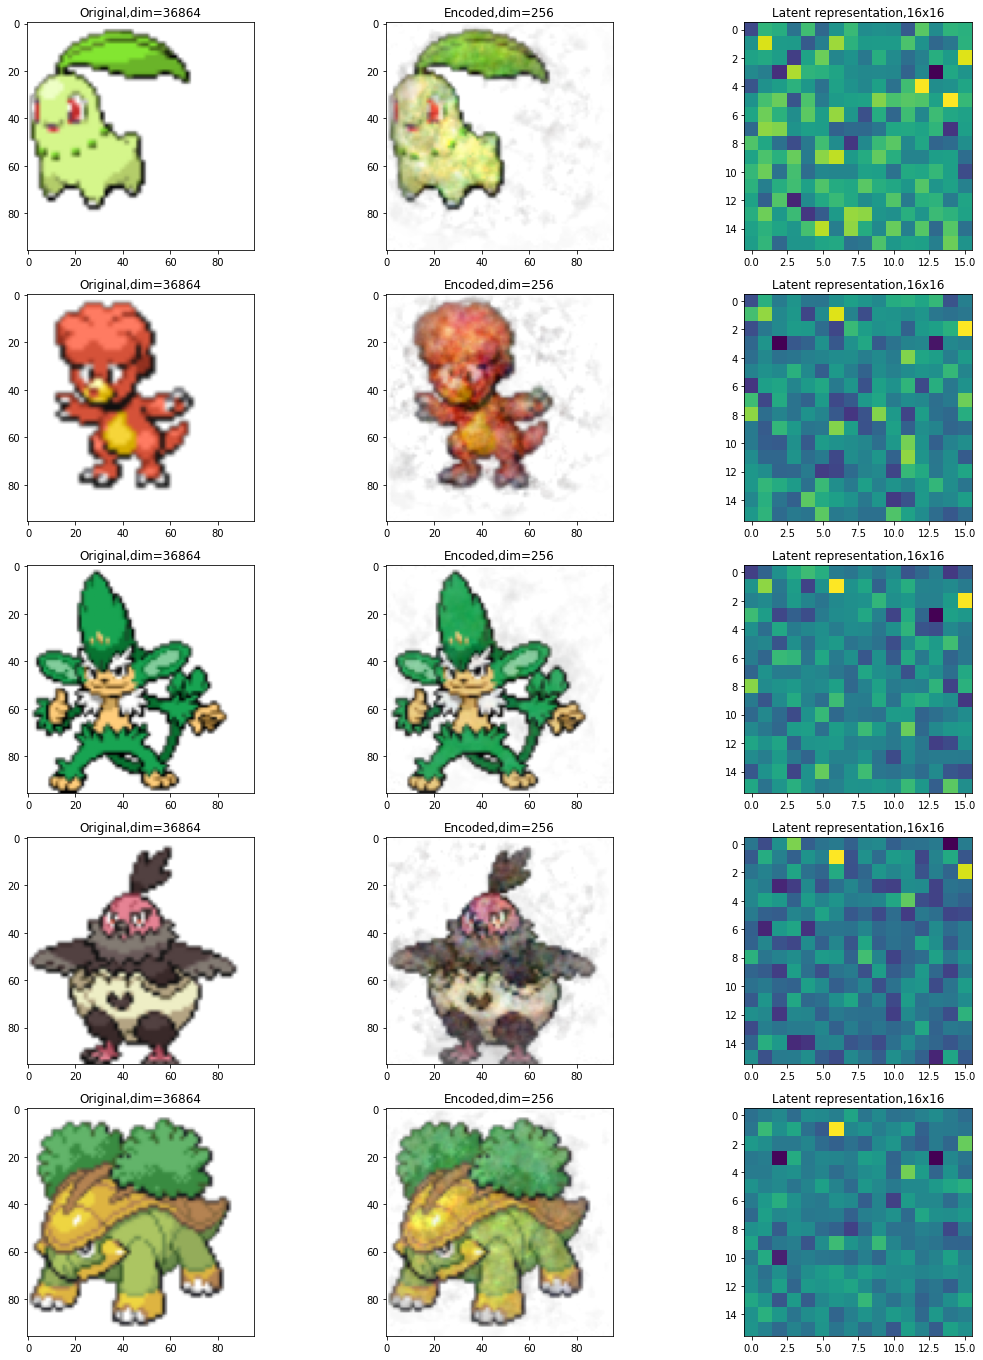

In [ ]:

def result(idx):
  image_path=os.path.join(dir,files_[idx])
  image=io.imread(image_path)
  img=transforms.ToTensor()(image)
  tmp=model(img.flatten().to(device)).cpu()
  encoded_data=model.encoder(img.flatten().to(device)).cpu()
  tmp = tmp.reshape(img.shape)
  tmp = tmp.permute(1, 2, 0)
  tmp = tmp.detach().numpy()
  img = img.permute(1, 2, 0)
  img = img.detach().numpy()
  encoded_data = encoded_data.detach().numpy()
  return img,tmp,encoded_data



rows=5 #number of samples
f, axs = plt.subplots(rows, 3, figsize=(16, 19))
for i in range(rows):
  idx=random.randint(0,len(files_))
  print(idx)
  img, img_recon, latent_representation=result(idx)
  axs[i,0].imshow(img)
  axs[i, 0].set_title(f'Original,dim={size*size*4}')
  axs[i,1].imshow(img_recon)
  axs[i, 1].set_title(f'Encoded,dim={input_layer_size//4}')
  axs[i,2].imshow(latent_representation.reshape(16,16))
  axs[i, 2].set_title(f'Latent representation,{16}x{16}')  
plt.tight_layout();

In [ ]:
#log checkpoint to drive
torch.save(model.state_dict(), save_file)

**Encoding the whole Dataset: **

In [ ]:
import time
start = time.time()
encoded_data=torch.zeros(len(files_),compressed_size)
i=0
for path in files_:
  
  image_path=os.path.join(dir,path)
  image=io.imread(image_path)
  img=transforms.ToTensor()(image)
  tmp=model(img.flatten().to(device)).cpu()
  encoded_data[i,:] =model.encoder(img.flatten().to(device)).cpu()
  i+=1
print("Time to encode all the images in the dataset=",time.time()-start)	
print(encoded_data.shape)
encoded_data=encoded_data.detach().numpy()
torch.save(encoded_data, 'encoded_data')

Time to encode all the images in the dataset= 3.607370376586914
torch.Size([753, 256])


**Image generation**

In the generative part of this project we'll use a DC-GAN Taking as input the latent representation (reshaped to 16x16) outputed by the encoder.

In [ ]:


# Set random seed for reproducibility
manualSeed = 912
Gsize=16 
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  912


In [ ]:
class EncodedDataset(Dataset):
  def __init__(self,enc_matrix,transform=None):
    
    self.enc_matrix=enc_matrix #matrix np array with data as rows
    self.transform=transform
  def __len__(self):
    return self.enc_matrix.shape[0]

  def __getitem__(self,idx):
    Gsize=int(np.sqrt(self.enc_matrix.shape[1]))
    image=self.enc_matrix[idx].reshape(Gsize,Gsize,1)

    if self.transform:
          image = self.transform(image)
    return image


dataset = EncodedDataset(enc_matrix=encoded_data, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])) 
Dataloader= torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [ ]:
import torchvision.utils as vutils
# Plot some training images
real_batch = next(iter(Dataloader))
print(real_batch.shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))




In [22]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
# Root directory for dataset

workers = 2
batch_size = 64  

image_size = 16

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 50
# Size of feature maps in generator
ngf = 8
# Size of feature maps in discriminator
ndf = 8
num_epochs = 5
lr = 0.0002

beta1 = 0.5
ngpu=1


In [15]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 2 x 2 
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 4 x 4
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 8 x 8
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            #state size. (nc) x 16 x 16
        )

    def forward(self, input):
        return self.main(input)

In [ ]:


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

#get summary
summary(netG, (nz,1,1))



NameError: ignored

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 16 x 16
            nn.Conv2d(4, ndf, 5, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 8 x 8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
device = torch.device("cuda")

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

#summary
summary(netD, (4,96,96))


Discriminator(
  (main): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)
-----------------------------------------

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.000002, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs=200
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for data in dataloader:
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
       
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G

        fake =netG(noise).reshape(b_size,1,1,256)

        fake=model.decoder(fake).reshape(b_size,4,size,size)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
         
        iters += 1


    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch, num_epochs, i, len(dataloader),
              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

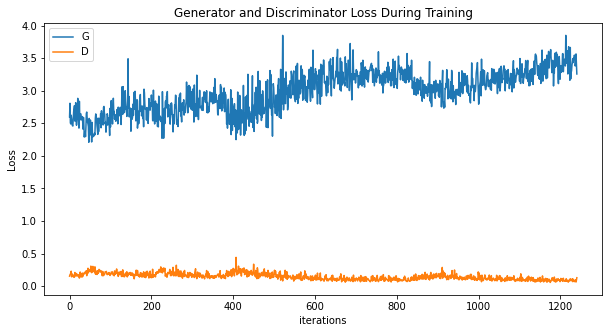

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
noise = torch.randn(1,nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)
fake_map =fake.cpu().detach().numpy()
#print(fake_map)

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


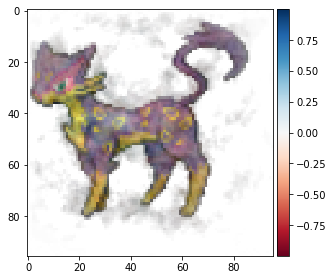

In [ ]:

gen_img=model.decoder(fake.view(-1))
gen_img=gen_img.reshape(4,size,size)
gen_img = gen_img.permute(1, 2, 0).cpu().detach().numpy()

io.imshow(gen_img[:,:,])




Mode collapse ...

# **No encoding**

In [26]:
nz=120

#lets try no encoding
class Generator2(nn.Module):
    def __init__(self, ngpu):
        super(Generator2, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*4) x 2 x 2 
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*2) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            #state size. (nc) x 16 x 16
            nn.ConvTranspose2d( ngf*2 , ngf, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, 4, 6, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [27]:

# Create the generator
netG2 = Generator2(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG2 = nn.DataParallel(netG2, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG2.apply(weights_init)

# Print the model
print(netG2)

#get summary
summary(netG2, (nz,1,1))


Generator2(
  (main): Sequential(
    (0): ConvTranspose2d(120, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (13): Ba

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Save files
save_fileD='/content/gdrive/MyDrive/Project_Ganimals/Autoencoder_checkpoint/discriminator.pth'
save_fileG='/content/gdrive/MyDrive/Project_Ganimals/Autoencoder_checkpoint/generator.pth'
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.00002, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG2.parameters(), lr=0.00002, betas=(beta1, 0.999))

netD.load_state_dict(torch.load(save_fileD))
netG2.load_state_dict(torch.load(save_fileG))

<All keys matched successfully>

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs=700
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for data in dataloader:
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = DiffAugment(data,policy=policy).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
       
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 120, 1, 1, device=device)
        # Generate fake image batch with G

        fake =  DiffAugment(netG2(noise),policy=policy)
        label.fill_(fake_label)

        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG2.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
         
        iters += 1

    if epoch % 15 == 0:
    
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      torch.save(netD.state_dict(), save_fileD)
      torch.save(netG2.state_dict(), save_fileG)

Starting Training Loop...
[0/700][4/12]	Loss_D: 0.4827	Loss_G: 1.5473	D(x): 0.8516	D(G(z)): 0.2618 / 0.2404
[15/700][4/12]	Loss_D: 1.1805	Loss_G: 1.4198	D(x): 0.4439	D(G(z)): 0.2452 / 0.2661
[30/700][4/12]	Loss_D: 0.4203	Loss_G: 1.4930	D(x): 0.9093	D(G(z)): 0.2647 / 0.2488
[45/700][4/12]	Loss_D: 0.9351	Loss_G: 1.4302	D(x): 0.5701	D(G(z)): 0.2652 / 0.2689
[60/700][4/12]	Loss_D: 0.7702	Loss_G: 1.4078	D(x): 0.6635	D(G(z)): 0.2516 / 0.2666
[75/700][4/12]	Loss_D: 0.5908	Loss_G: 1.7412	D(x): 0.7570	D(G(z)): 0.2376 / 0.2321
[90/700][4/12]	Loss_D: 0.9159	Loss_G: 1.2018	D(x): 0.6412	D(G(z)): 0.3315 / 0.3436
[105/700][4/12]	Loss_D: 0.5332	Loss_G: 1.3363	D(x): 0.8640	D(G(z)): 0.3076 / 0.2862
[120/700][4/12]	Loss_D: 1.0646	Loss_G: 1.3102	D(x): 0.5151	D(G(z)): 0.2799 / 0.2958
[135/700][4/12]	Loss_D: 0.3828	Loss_G: 2.3486	D(x): 0.7846	D(G(z)): 0.1133 / 0.1199
[150/700][4/12]	Loss_D: 0.7659	Loss_G: 1.6761	D(x): 0.6246	D(G(z)): 0.2209 / 0.2100
[165/700][4/12]	Loss_D: 0.3861	Loss_G: 1.3895	D(x): 0.9629

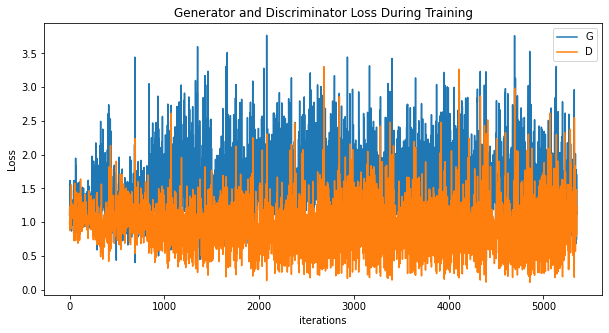

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 120, 1, 1])
(4, 96, 96)


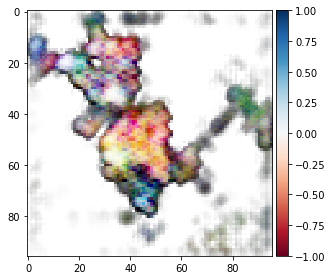

In [52]:
noise = torch.randn(1,120, 1, 1, device=device)
print(noise.shape)
# Generate fake image batch with G
fake = netG2(noise).reshape(4,size,size)
fake_map =fake.cpu().detach().numpy()
print(fake_map.shape)

gen_img = fake.permute(1, 2, 0).cpu().detach().numpy()

io.imshow(gen_img[:,:,])
